# Tutorial08: Graph Neural Networks (GNN)
> Created Aug. 2024 for the FSU Course: *Machine Learning in Physics* <br>
> H. B. Prosper<br>


## Introduction
In this tutorial we build a **graph neural network** (GNN) similar to the one developed in the award-winning work by the IceCube Collaboration[1] which yielded state-of-the-art results in neutrino event classification.
Our goal is to classify events as **signal** or **background**, where each event is modeled as a list of data pertaining to particles, specifically: the transverse momentum of a particle, $p_T$, and its direction $(\eta, \phi)$. The quantity $\eta = -\log\tan (\theta/2)$ is the pseudo-rapidity and $\theta$ the polar angle, and $\phi$ is the azimuthal angle.

In mathematics, a **graph** is a tuple $G = (V, E)$ of two sets $V = \{v_1,\cdots\}$ and $E = \{e_1,\cdots\}$ where $V$ is a set of **vertices** (or nodes) connected by **edges** that form a set $E$.
<img src="./graph.png" align="left" width="250px"/> Graphs are closely related to **point clouds**, which is literally a cloud of points in some vector space. In this tutorial, each data instance, that is, event, is a point cloud $P = \{ (p_T, \eta, \phi)_i \}_{i=1}^n \in \mathbb{R}^d$, where $d = 3$ and where, in general, the number of points $n$, that is, particles, varies from one point cloud to the next. The subset of data used in this tutorial come from the website [LHC Olympics 2020](https://lhco2020.github.io/homepage/), which you should consult for a detailed description of the particle collision events. 

Because the number of points varies from one point cloud to the next, we shall train the GNN with a batch size of one.
<br clear="left"/>


## References
  1. N. Choma et al. IceCube collaboration, Graph Neural Networks for IceCube Signal Classification,  arXiv:1809.06166v1.

## Tips

  * Use __esc r__ to disable a cell
  * Use __esc y__ to reactivate it
  * Use __esc m__ to go to markdown mode. **Markdown** is the typesetting language used in jupyter notebooks.
  * In a markdown cell, double tap the mouse or glide pad (on your laptop) to go to edit mode. 
  * Shift + return to execute a cell (including markdown cells).
  * If the equations don't typeset, try double tapping the cell again, and re-execute it.

In [2]:
# standard system modules
import os, sys

sys.path.append('../../python')

# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np

# module to access data in Hierarchical Data Format (HDF or H5 format)
import h5py

# to reimport Python modules
import importlib

# standard module for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn
import torch.nn.functional as F

import lossmonitor as lm

from tqdm import tqdm

# update fonts
FONTSIZE = 12
plt.rcParams.update({
    "text.usetex": True, # turn off if the system can't find late
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "font.size": FONTSIZE
})

# set a seed to ensure reproducibility
seed = 4321
rnd  = np.random.RandomState(seed)

## Constants

In [3]:
DATAFILE = '../data/events.h5'

PARAMS_FILE = 'GNN.pth' # file containing parameters of trained model

LOSS_FILE = 'losses.csv'

TIMELEFT_FILE = 'timeleft.txt'

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Available device: {str(DEVICE):4s}')

Available device: cpu 


## Load Data
The dataset comprises 36,000 events divided equally between signal and background that have been randomly shuffled. The targets can be accessed using the key 'targets' and an event is accessed by specifying the event number  'N', with the first event being '0'.

In [4]:
def load_data(filename):
    hdf = h5py.File(filename, "r")
    
    targets = torch.tensor(np.array(hdf['targets']))
    
    events = []
    pt = []
    for i in tqdm(range(len(targets))):
    
        # create event key into hdf file
        key = f'{i:d}'
    
        # get array of particles
        event = np.array(hdf[key])

        # make sure data are ok
        if np.isnan(event).sum() > 0:
            raise ValueError(f'event {i:d} contains at least one NAN')
            
        # accumulate transverse momenta (to compute mean and stdev)
        pt += list(event[:, 0])
    
        # convert every array to a tensor and send to computational device
        event = torch.Tensor(event).to(DEVICE)
    
        # cache the tensor in a Python list
        events.append(event)
    
    pt = np.array(pt)
    
    print(f'E[pt]: {pt.mean():8.1f} GeV, Std[pt]: {pt.std():8.1f} GeV')
    
    return targets, events

targets, events = load_data(DATAFILE)

targets.shape, events[0].shape

100%|███████████████████████████████████| 36000/36000 [00:04<00:00, 7619.14it/s]


E[pt]:     20.2 GeV, Std[pt]:     60.9 GeV


(torch.Size([36000]), torch.Size([111, 3]))

## Plot Events

The particle's transverse momentum is proportional to the area of the markers.

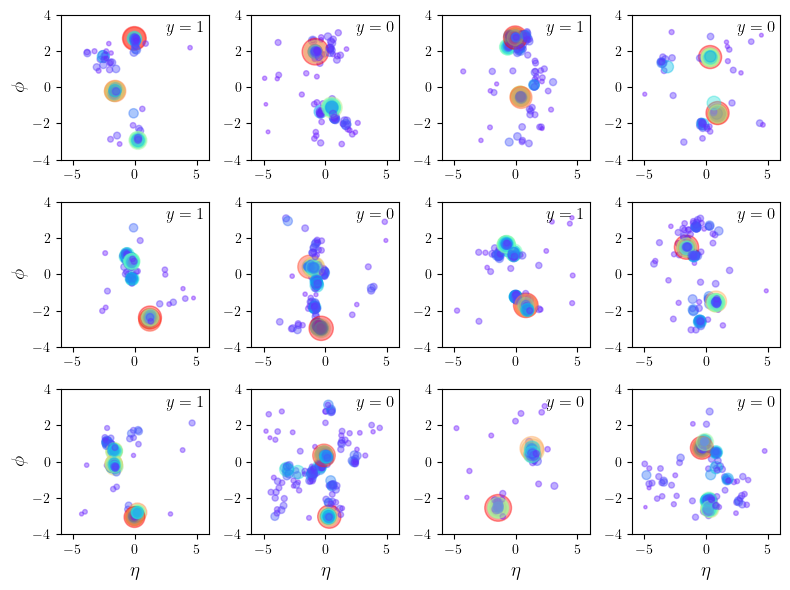

In [5]:
def plot_events(targets, events, ndata=12, ptscale=25, scale=80,
                xmin=-6.0, xmax=6.0,
                ymin=-4.0, ymax=4.0, 
                filename='events.png',
                ftsize=14):
    
    plt.rcParams.update({'font.size': 10})

    # work out number of columns and number of plots
    ncols = 4
    nrows = ndata // ncols
    ndata = nrows * ncols
    fgsize= (2*ncols, 2*nrows)
        
    # create an empty figure
    fig = plt.figure(figsize=fgsize)

    # loop over number of point clouds, ndata
    for i in range(ndata):
        index = i+1
        ax = fig.add_subplot(nrows, ncols, index)
        
        # setup axes
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        
        if i > (nrows-1) * ncols-1:
            ax.set_xlabel(r'$\eta$', fontsize=ftsize)
        
        if i % ncols == 0:
            ax.set_ylabel(r'$\phi$', fontsize=ftsize)

        # get point cloud (i.e., event).
        # area of points in (eta, phi) proportional to pT of particle
        pt, eta, phi = events[i].T
        y = targets[i]
        
        size = scale * np.sqrt(pt / ptscale)
        cmap = mp.colormaps['rainbow']
        colors = cmap(size / size.max(), alpha=0.4)

        ax.scatter(eta, phi, s=size, c=colors)

        ax.text(2.5, 3.0, f'$y = {y:d}$', fontsize=12)
    
    fig.tight_layout()
    plt.savefig(filename)
 
plot_events(targets, events)

## Plot Distribution of Particle Count

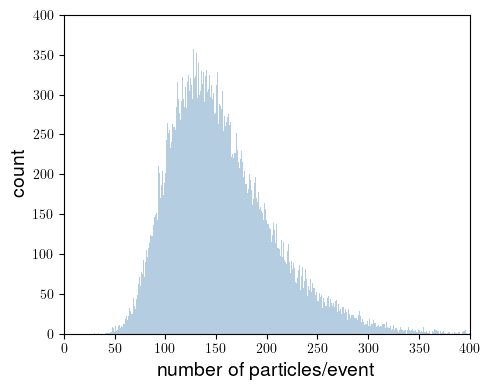

In [6]:
def plot_multiplicity(events, 
                      xmin=0, xmax=400,
                      ymin=0, ymax=400, 
                      filename='multiplicity.png',
                      fgsize=(5, 4),
                      ftsize=14):

    # create an empty figure
    fig = plt.figure(figsize=fgsize)
    
    nrows, ncols, index = 1, 1, 1
    ax = fig.add_subplot(nrows, ncols, index)
        
    # setup axes
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    ax.set_xlabel(r'number of particles/event', fontsize=ftsize)
    ax.set_ylabel(r'count', fontsize=ftsize)

    N = len(events)
    x = [len(events[i]) for i in range(N)]
    ax.hist(x, bins=xmax, range=(xmin, xmax), color='steelblue', alpha=0.4)

    fig.tight_layout()
    plt.savefig(filename)

plot_multiplicity(events)

## Prepare Training, Validation, and Test Datasets
  1. Scale data
  2. Split data into training, testing, and validation sets.
  3. Move them to computational device.

In [7]:
#                       pT, eta,   phi
scale = torch.Tensor([[100,   5, np.pi]]).to(DEVICE)

X = [event / scale for event in events]

In [8]:
n_train = 30000
n_test  =  5000
n_valid =  len(targets) - n_train - n_test

# split and convert to tensors

train_x, X = X[:n_train],  X[n_train:]
train_y, Y = targets[:n_train], targets[n_train:]

test_x, valid_x = X[:n_test], X[n_test:]
test_y, valid_y = Y[:n_test], Y[n_test:]

print("Size of training set:   %10d" % len(train_x))
print("Size of test set:       %10d" % len(test_x))
print("Size of validation set: %10d" % len(valid_x))

Size of training set:        30000
Size of test set:             5000
Size of validation set:       1000


## Utilities
  1. $\texttt{delta\_phi}$ - computes $\phi_2 - \phi_1$ accounting for the wraparound.
  2. $\texttt{number\_of\_parameters}$ - returns the number of model parameters to be fitted.

In [9]:
def delta_phi(phi2, phi1):
    deltaphi = phi2 - phi1
    abs_deltaphi = torch.abs(deltaphi)
    deltaphi = torch.where(abs_deltaphi > torch.pi, 
                           2 * torch.pi - abs_deltaphi, 
                           abs_deltaphi)
    return deltaphi

def number_of_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Building a Model as a Python Class

The **nn.Sequential** class is the simplest way to construct (simple) PyTorch models. But if you want more control over the model, you can achieve this by building the model as a class inheriting from **nn.Module** as in the following. 

### $\texttt{Edges}$
This class computes the adjacency matrix $E \equiv A$ given vertices $V$. An event with $n$ particles can be modeled as a graph with $n$ vertices. Inspired by IceCube, we model the edges of the graph as an $n \times n$ adjacency matrix $A$ where the matrix elements are given by
\begin{align}
    d_{ij} & = \exp(-\alpha \| x_i - x_j \|^2), \\
    A_{ij} & = \texttt{softmax}(d_{ij}, \, \texttt{dim}=1) ,
\end{align}
where $x_i = (\eta_i, \phi_i)$ and $\alpha$ is a free parameter. Following IceCube, the adjacency matrix is not changed by the graph convolution operation, but does of course change from one graph to the next.

Since the maximum number of particles is less than about 400 with the median of about 160, it is still feasible to construct $n \times n$ matrices. For much larger $n$ one would have to use sparse matrix representations of the adjacency matrix. The $-1$ in a given tensor dimension indicates that the number of elements in that dimension is determined at runtime. In this example, that number will be the number of particles $n$.

#### A note on array broadcasting
**Broadcasting** is a powerful mechanism that makes it possible to perform many useful array or tensor manipulations. The $\texttt{Edges}$ class uses broadcasting to compute all possible $\eta$ and $\phi$ differences $\Delta \eta_{ij} = \eta_i - \eta_j$ and $\Delta \phi_{ij} = \phi_i - \phi_j$ between the $n$ particles.  By changing the shapes of the tensors $\texttt{eta}$ and $\texttt{phi}$ using $\texttt{view(-1, 1)}$ and $\texttt{view(1, -1)}$, that is, by changing their shapes to a 2D tensor containing a single column and a 2D tensor containing a single row, respectively, all possible $\eta$ and $\phi$ differences can be computed. 

Conceptually, what happens is this. The single-column tensor constructed using $\texttt{view(-1, 1)}$ is  replicated to form a tensor of shape $(n, n)$ in which every *column* is identical. Likewise, the single-row tensor constructed using $\texttt{view(1, -1)}$ is replicated to form a tensor of shape $(n, n)$ in which every row is identical. Now that the tensors are of the same shape, an elementwise subtraction is performed on the two $n \times n$ tensors, resulting in 2D tensors of shape $(n, n)$ containing all possible differences. 

In [10]:
class Edges(nn.Module):
    '''
    Given a set of vertices V, compute adjacency matrix of shape (n, n).
    '''    
    def __init__(self, alpha=1, device=DEVICE):

        super().__init__()

        # Note use of Parameter to tell PyTorch that the parameter alpha
        # is to be fitted.
        self.alpha = nn.Parameter(alpha * torch.rand(1))

        self.device = device
        
    def forward(self, x):

        # 1. compute square of Euclidean distance in (eta, phi) space
        #    dR^2 = deta^2 + dphi^2
        eta, phi = x[:, 1], x[:, 2]
        # use broadcasting to compute all possible differences
        deta = eta.view(-1, 1) - eta.view(1, -1)
        dphi = delta_phi(phi.view(-1, 1), phi.view(1, -1))
        dRdR = deta**2 + dphi**2

        # 2. compute exp(- alpha * dR)**2)
        A = torch.exp(-self.alpha * dRdR)

        # 3. apply softmax in horizontal direction.
        #    adding a unit matrix to the adjacency matrix 
        #    makes the training more stable. we need to send
        #    the unit matrix to the computatational device.
        A = torch.softmax(A, dim=1) + torch.eye(len(x)).to(self.device)
        
        return A

### Graph Convolution Layer: $\texttt{GCNLayer}$
Here we implement a simple graph convolutional layer from scratch, which differs slightly from the IceCube implementation.
As in most GNNs, the vertices are concatenated into a matrix, $X$, of shape $(n, d)$. Given a weight matrix $w$ of shape $(h, h)$, where generally $h > d$, and a matrix of ones of shape $(n, h)$ scaled by the bias parameter $b$, the graph convolution operation is defined by
\begin{align}
    X & \leftarrow \sigma(X W^T + B),\\
    X & \leftarrow \sigma((A X) w + b \mathbb{I}) ,
\end{align}
that is, a linear function to which a nonlinear operation, $\sigma(*)$, is applied (usually, element wise), followed by another linear function involving the adjacency matrix, which is then subject to a nonlinear operation. 

For each vertex, the matrix operation $A X$ computes a weighted sum of the features of its neighboring vertices. Since we're following the IceCube model, for a given vertex all other vertices are its neighbors. However, the closer neighbors are weighted more than those further away. The tunable parameter $\alpha$ in the adjacency matrix $A$ determines the scale of the nearest neighbor domains.  For each vertex, whose feature vector is now of dimension $\texttt{n\_embed} = h$, $h$ weighted sums of its features are computed using the $h$ columns of the $h \times h$ matrix of parameters $w$. The same bias $b$ is added to every element of the resulting $(n, h)$-shaped matrix and, finally, each element is subjected to a nonlinear function. 

IceCube uses concatenations in their award-winning implementation. We avoid concatenations in our implememntation because they seem to be a bit sluggish in PyTorch.

In [11]:
class GCNLayer(nn.Module):
    
    def __init__(self, in_features, out_features, scale=0.05):

        # initialize base class
        super().__init__()

        # we embed the "n" input vertices in a larger vector space 
        # of dimension h = out_features
        self.embed  = nn.Linear(in_features, out_features)
        
        self.weight = nn.Parameter(scale * (2*torch.rand(out_features, out_features)-1.0))
        self.bias   = nn.Parameter(scale * (2*torch.rand(1)-1.0))

    def forward(self, X, A):

        # embed vertices in a larger vector space
        X = self.embed(X)
        X = F.relu(X)

        # perform graph convolution. for each vertex, this operation
        # performs a weighted sum of the features of all other vertices,
        # weighting the nearest neighbors more heavily.
        # AX = A * X
        AX = torch.matmul(A, X)

        # compute (A * X) * W + B * I
        X = torch.matmul(AX, self.weight) + self.bias * torch.ones_like(X)
        X = F.relu(X)

        # return modified vertices  
        return X

class InvariantFunction(nn.Module):
    '''
    Perform a permutation and vertex count-invariant operation on the
    vertices of a graph.
    '''
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        #print('x.shape, x', x.shape, x)
        m = x.mean(dim=0)
        s = x.std(dim=0)
        #print('mean, std', m, s)
        return m

### Graph neural network (GNN)

In [12]:
class GNN(nn.Module):
    
    def __init__(self, n_dim, n_embed=40, dropout=0.5):

        # initialize base class
        super().__init__()

        self.edges  = Edges()
        self.gconv1 = GCNLayer(n_dim,   n_embed)
        self.gconv2 = GCNLayer(n_embed, n_embed)
        self.func   = InvariantFunction()
        self.linear = nn.Linear(n_embed, 1)

        self.dropout= nn.Dropout(dropout)

    def forward(self, x):

        # construct n x n adjacency matrix which together
        # with the vertices V = x forms the graph G = (V, E)
        V = x
        E = self.edges(V)
        
        # pass graph G = (V, E) through multiple
        # graph convolution layers (graph processors)
        V = self.gconv1(V, E)
        V = F.relu(V)
        
        V = self.dropout(V)
        
        V = self.gconv2(V, E)
        V = F.relu(V)

        V = self.dropout(V)
        
        # apply a permutation- and vertex count-invariant
        # function to the vertices 
        x = self.func(V)

        # complete with a simple MLP
        x = self.linear(x)     
        x = F.sigmoid(x)
        
        return x

    def save(self, paramsfile):
        # save parameters of neural network
        torch.save(self.state_dict(), paramsfile)

    def load(self, paramsfile):
        # load parameters of neural network
        self.eval()
        self.load_state_dict(torch.load(paramsfile, 
                                        map_location=torch.device(DEVICE)))
        

### Define empirical risk (aka average loss)

In [13]:
# Note: there are several average loss functions available 
# in PyTorch, but it's useful to know how to create your own.
def average_quadratic_loss(f, t):
    # f and t must be of the same shape
    return  torch.mean((f - t)**2)

def average_cross_entropy_loss(f, t):
    # f and t must be of the same shape
    # f = torch.where(f >= 1, 0.9999, f)
    losses = torch.where(t > 0.5, torch.log(f), torch.log(1-f))
    return -torch.mean(losses)

### Empirical risk
Ordinarily, the calculation of the empirical risk would leverage the implied loop over batch elements provided by $\texttt{PyTorch}$. However, this requires each batch element to be of the same size. Our implementation of the empirical risk computes the loss for each point cloud one point cloud at a time, which of course is much slower. But this is done to account for the fact that the number of points per point cloud can vary from one instance to the next. We'll generally choose a batch size of 1 and a small learning rate.

In [14]:
def empirical_risk(model, lossfn, X, Y): 
    out = model(X[0]) 
    loss = lossfn(out, Y[0])

    for x, y in zip(X[1:], Y[1:]):
        out = model(x)
        loss += lossfn(out, y)
    loss /= len(X)
    return loss

## A Simple Dataloader
This dataloader simply cycles through the training set, except if the batch size is one in which case a randomly selected event is returned.

In [15]:
class DataLoader:
    
    def __init__(self, X, T, batch_size=1):
        self.X = X
        self.T = T
        
        self.B = batch_size
        self.N = len(X)
        #print('Dataloader.N', self.N)
        
        self.reset()
        
    def reset(self):
        self.M = self.N / self.B      # of batches / training data
        self.J = int(self.M) + 1
        #print('Dataloader.M', self.M)
        
        self.start = 0
        self.end = B
        self.ii = -1
        
    def __call__(self, ii=-1):

        if ii > self.ii:

            # update start and end of batch
            
            if self.B < 2:  # assume random selection
                self.start = torch.randint(0, self.N-1, size=(1,))
                self.end = self.start + 1
                
            else:           # assume we're cycling through training data
                self.J += 1
                if self.J >= self.M:
                    self.J = 0
                    self.start = 0
                    self.end = self.B
                else:
                    self.start += self.B
                    self.end = self.start + self.B
                    if self.end > self.N:
                        self.end = self.N

        self.ii = ii
        
        return self.X[self.start:self.end], self.T[self.start:self.end]
        

### Test DataLoader

In [16]:
X = [0,1,2,3,4,5,6]
Y = [0,11,22,33,44,55,66]
B = 3

dataloader = DataLoader(X, Y, B)

for i in range(10):
    x, y = dataloader(i)
    print(f'{i:5d}\t{str(x):10s}\t{str(y):10s}')

print()

dataloader.reset()

for i in range(10):
    x, y = dataloader()
    print(f'{i:5d}\t{str(x):10s}\t{str(y):10s}')


    0	[0, 1, 2] 	[0, 11, 22]
    1	[3, 4, 5] 	[33, 44, 55]
    2	[6]       	[66]      
    3	[0, 1, 2] 	[0, 11, 22]
    4	[3, 4, 5] 	[33, 44, 55]
    5	[6]       	[66]      
    6	[0, 1, 2] 	[0, 11, 22]
    7	[3, 4, 5] 	[33, 44, 55]
    8	[6]       	[66]      
    9	[0, 1, 2] 	[0, 11, 22]

    0	[0, 1, 2] 	[0, 11, 22]
    1	[0, 1, 2] 	[0, 11, 22]
    2	[0, 1, 2] 	[0, 11, 22]
    3	[0, 1, 2] 	[0, 11, 22]
    4	[0, 1, 2] 	[0, 11, 22]
    5	[0, 1, 2] 	[0, 11, 22]
    6	[0, 1, 2] 	[0, 11, 22]
    7	[0, 1, 2] 	[0, 11, 22]
    8	[0, 1, 2] 	[0, 11, 22]
    9	[0, 1, 2] 	[0, 11, 22]


### Train model

In [17]:
def train(model, optimizer, lossfn, 
          t_dataloader, v_dataloader1, v_dataloader2,
          number_iterations,
          lossfile=LOSS_FILE,
          timeleftfile=TIMELEFT_FILE,
          paramsfile=PARAMS_FILE,
          step=100):

    # this object writes the losses to a csv file, whose
    # contents can be displayed in realtime with the
    # command python monitor_losses.py losses.csv
    
    losswriter = lm.LossWriter(model, 
                               number_iterations, 
                               lossfile, timeleftfile, paramsfile, 
                               step)
    
    # ------------------------------------------
    # enter training loop
    # ------------------------------------------
    
    for ii in range(number_iterations):
        
        # set mode to training so that training-specific 
        # operations such as dropout, etc., are enabled.

        model.train() # training mode

        x, y = t_dataloader(ii)
        
        loss = empirical_risk(model, lossfn, x, y)
    
        optimizer.zero_grad()  # clear previous gradients
    
        loss.backward()        # compute gradients
    
        optimizer.step()       # move one step
    
        # i'm alive printout
        
        if (ii % step == 0): #and (ii > 0):

            with torch.no_grad():
                
                model.eval()
                
                # compute average loss on train data
                x, y = v_dataloader1()
                t_loss = empirical_risk(model, lossfn, x, y).detach()

                # compute average loss on validation data
                x, y = v_dataloader2()
                v_loss = empirical_risk(model, lossfn, x, y).detach()
     
            losswriter(ii, t_loss, v_loss)

    print()      
    return 

## Instantiate Model

In [18]:
_, n_dimensions = train_x[0].shape

model = GNN(n_dimensions).to(DEVICE)
print('number of parameters:', number_of_parameters(model))

print(model)
print()

print('Paramters\n')
for name, p in model.named_parameters():
    if p.requires_grad:
        print(name)

avloss = average_cross_entropy_loss

t_dataloader  = DataLoader(train_x, train_y)
v_dataloader1 = DataLoader(train_x, train_y, n_valid)
v_dataloader2 = DataLoader(valid_x, valid_y, n_valid)

number of parameters: 5044
GNN(
  (edges): Edges()
  (gconv1): GCNLayer(
    (embed): Linear(in_features=3, out_features=40, bias=True)
  )
  (gconv2): GCNLayer(
    (embed): Linear(in_features=40, out_features=40, bias=True)
  )
  (func): InvariantFunction()
  (linear): Linear(in_features=40, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Paramters

edges.alpha
gconv1.weight
gconv1.bias
gconv1.embed.weight
gconv1.embed.bias
gconv2.weight
gconv2.bias
gconv2.embed.weight
gconv2.embed.bias
linear.weight
linear.bias


## Train Model

In [19]:
DELETE_LOSS_FILE = True

TRAIN = True

if DELETE_LOSS_FILE:
    os.system(f'rm -f {LOSS_FILE:s}')

if TRAIN:

    # Train in steps

    # STEP 1
    n_iterations = 150001
    step = 100
    learning_rate = 1e-3
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train(model, optimizer, avloss, 
          t_dataloader, v_dataloader1, v_dataloader2, 
          n_iterations,
          LOSS_FILE, TIMELEFT_FILE, PARAMS_FILE, 
          step)

    # STEP 2
    n_iterations = 150001
    step = 100
    learning_rate = 4e-4
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train(model, optimizer, avloss, 
          t_dataloader, v_dataloader1, v_dataloader2, 
          n_iterations,
          LOSS_FILE, TIMELEFT_FILE, PARAMS_FILE, 
          step)

    # STEP 2
    n_iterations = 200001
    step = 100
    learning_rate = 1e-4
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train(model, optimizer, avloss, 
          t_dataloader, v_dataloader1, v_dataloader2, 
          n_iterations,
          LOSS_FILE, TIMELEFT_FILE, PARAMS_FILE, 
          step)

    150001|100.00%|00:10:36/00:00:00| 235.8 it/s|      150000|  0.26081076|  0.22213578|

    150001|100.00%|00:10:34/00:00:00| 236.3 it/s|      300000|  0.31633580|  0.29226899|

    200001|100.00%|00:14:15/00:00:00| 233.8 it/s|      500000|  0.26225051|  0.28124878|



## Plot Results

  1. Confusion matrix for signals defined by $y \geq 1/2$.
  2. Classifier distribution $\hat{y} = D(G)$.
  3. ROC curve

**NB**: In the following codes, the first argument is always the targets $y$ and the second the model predictions $\hat{y}$.

In [20]:
def plot_confusion_matrix(y, y_pred, gfile='confusion_matrix.png'):
    from sklearn.metrics import confusion_matrix
    
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_true=y, y_pred=y_pred)

    # plot the confusion matrix using matplotlib
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(conf_matrix, cmap=plt.cm.rainbow, alpha=0.4)

    # annotate each plot with target
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], 
                    va='center', ha='center', size='x-large')
 
    plt.xlabel('Predicted Labels', fontsize=16)
    plt.ylabel('True Labels', fontsize=16)
    plt.title(f'Confusion Matrix', fontsize=16)
    
    fig.tight_layout()
    plt.savefig(gfile)

100%|██████████████████████████████████████| 5000/5000 [00:09<00:00, 518.43it/s]


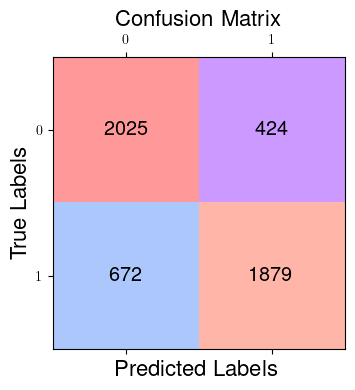

In [21]:
model.load(PARAMS_FILE)

y_hat = []
for i in tqdm(range(len(test_x))):
    y_hat.append(float(model(test_x[i]).data.cpu()))

y_hat  = np.array(y_hat)
y_pred = (y_hat > 0.5).astype(int)
y_true = test_y.data.cpu().numpy()

plot_confusion_matrix(y_true, y_pred)

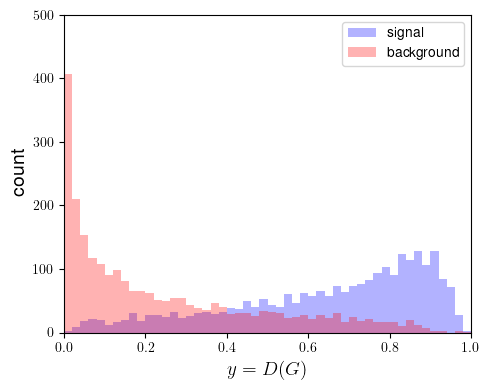

In [22]:
def plot_outputs(y, yhat, 
                 xbins=50, xmin=0, xmax=1,
                 ymin=0, ymax=500, 
                 filename='outputs.png',
                 fgsize=(5, 4),
                 ftsize=14):

    # create an empty figure
    fig = plt.figure(figsize=fgsize)
    
    nrows, ncols, index = 1, 1, 1
    ax = fig.add_subplot(nrows, ncols, index)
        
    # setup axes
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    ax.set_xlabel(r'$y = D(G)$', fontsize=ftsize)
    ax.set_ylabel(r'count', fontsize=ftsize)

    s = yhat[y > 0.5]
    b = yhat[y < 0.5]
    
    ax.hist(s, bins=xbins, range=(xmin, xmax), color='blue', alpha=0.3, label='signal')
    ax.hist(b, bins=xbins, range=(xmin, xmax), color='red', alpha=0.3, label='background')
    ax.legend()
    
    fig.tight_layout()
    plt.savefig(filename)

plot_outputs(y_true, y_hat)

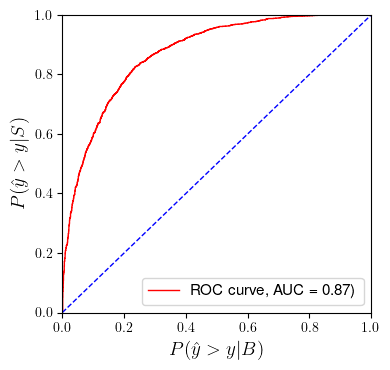

In [23]:
def plot_roc(y, yhat):
    # standard measures of model performance
    from sklearn.metrics import roc_curve, auc

    bkg, sig, _ = roc_curve(y, yhat)
    
    roc_auc = auc(bkg, sig)
    
    fig = plt.figure(figsize=(4.0, 3.8))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('$P(\\hat{y} > y | B)$', fontsize=14)
    plt.ylabel('$P(\\hat{y} > y | S)$', fontsize=14)
    
    plt.plot(bkg, sig, color='red',
             lw=1, label='ROC curve, AUC = %0.2f)' % roc_auc)
    
    plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

    plt.legend(loc="lower right", fontsize=11)
    fig.tight_layout()
    plt.savefig("ROC.png")

plot_roc(y_true, y_hat)